# DGD Training Demo: Using the DGDTrainer Class

This notebook demonstrates the complete usage of the DGDTrainer class from `src/training/trainer.py`. We'll train a Deep Generative Decoder (DGD) model on the FashionMNIST dataset using the standard production configuration, showcasing:

- Configuration setup using Hydra/OmegaConf with the standard config
- Dataset preparation and data loading
- ClearML integration for experiment tracking
- Model training with representation layers and GMM fitting
- Visualization of training progress and results
- Model evaluation and sample generation
- Model saving and loading

The DGD model combines:
- **Representation Layer**: Learnable per-sample embeddings in latent space
- **Convolutional Decoder**: Neural network that maps latent codes to images
- **Gaussian Mixture Model**: Probabilistic model fitted to the learned representations

**Note**: This demo uses the standard production configuration for full model capacity. If you have limited GPU memory, you can uncomment the memory optimization lines in the configuration section.

## 1. Setup Environment and Imports

First, let's import all necessary libraries and set up the environment.

In [17]:
import os
import sys
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from hydra import initialize, compose
from clearml import Task

current_dir = Path.cwd()
if 'notebooks' in current_dir.parts:
    project_root = current_dir.parent
else:
    project_root = current_dir

sys.path.append(str(project_root))
sys.path.append(str(project_root / 'src'))

from src.training.trainer import DGDTrainer
from src.data.dataloader import create_dataloaders, get_sample_batches
from src.models import RepresentationLayer, DGD, ConvDecoder

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
    num_devices = torch.cuda.device_count()
    print(f"Number of CUDA devices: {num_devices}")
    
    if num_devices > 1:
        max_memory = 0
        best_device = 0
        
        print("\nScanning devices for available memory:")
        for i in range(num_devices):
            total_memory = torch.cuda.get_device_properties(i).total_memory
            allocated_memory = torch.cuda.memory_allocated(i)
            reserved_memory = torch.cuda.memory_reserved(i)
            available_memory = total_memory - reserved_memory
            
            print(f"Device {i}: {torch.cuda.get_device_name(i)}")
            print(f"  Total Memory: {total_memory/1024**2:.2f} MB")
            print(f"  Allocated: {allocated_memory/1024**2:.2f} MB")
            print(f"  Reserved: {reserved_memory/1024**2:.2f} MB")
            print(f"  Available: {available_memory/1024**2:.2f} MB")
            
            if available_memory > max_memory:
                max_memory = available_memory
                best_device = i
        
        device = torch.device(f'cuda:{best_device}')
        torch.cuda.set_device(device)
        print(f"\n- Selected device {best_device} with {max_memory/1024**2:.2f} MB available memory")
    
    
    print(f"Using CUDA with {torch.cuda.get_device_name(device)} ({torch.cuda.get_device_properties(device).total_memory / 1e9:.1f} GB memory)")
else:
    device = torch.device('cpu')
    print(f"Using CPU")

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

try:
    from cuml.accel import install
    install()
except ImportError:
    print("Cuml not installed, using CPU for umap and sklearn")

print(f"PyTorch version: {torch.__version__}")
print(f"Project root: {project_root}")


Number of CUDA devices: 1
Using CUDA with NVIDIA GeForce RTX 4060 Laptop GPU (8.2 GB memory)
PyTorch version: 2.9.0+cu130
Project root: /home/asp/Downloads/HeaDS/ImageDGD


## 2. Load Configuration

Load the training configuration using Hydra/OmegaConf. We'll use the standard production configuration which provides full model capacity and training settings. You can optionally apply memory optimizations if running on limited hardware.

In [22]:
config_dir = project_root / "config"
relative_config_path = "../config"

with initialize(version_base=None, config_path=relative_config_path):
    config = compose(config_name="config")

print("CONFIGURATION")
print(f"{'='*60}")
print(OmegaConf.to_yaml(config))
print(f"{'='*60}")

CONFIGURATION
random_seed: 42
experiment_name: ImageDGD_Default
description: Default ImageDGD training configuration
data:
  dataset: FashionMNIST
  data_dir: ./data
  batch_size: 128
  num_workers: 4
  pin_memory: true
  use_subset: false
  subset_fraction: 1.0
  normalize: true
model:
  representation:
    n_features: 2
    distribution: uniform_ball
    dist_params:
      radius: 1.0
  decoder:
    hidden_dims:
    - 128
    - 64
    - 32
    output_channels: 1
    output_size:
    - 28
    - 28
    init_size:
    - 4
    - 4
    kernel_size: 3
    stride: 2
    padding: 1
    output_padding: 1
    bias: true
    normalization: batch
    activation: leaky_relu
    final_activation: sigmoid
    dropout_rate: 0.0
    upsampling_mode: transpose
    use_spectral_norm: false
    use_self_attention: false
    attention_resolution: 32
  gmm:
    n_components: 20
    n_features: null
    covariance_type: full
    max_iter: 1000
    tol: 0.0001
    reg_covar: 1.0e-06
    n_init: 1
    init_m

## 3. Prepare Dataset and Data Loaders

Load and prepare the FashionMNIST dataset with proper transformations and create data loaders.

Data directory: /home/asp/Downloads/HeaDS/ImageDGD/data
- Configuration updated for FashionMNIST dataset
- Added missing dataloader fields (dataset_name, root_dir, shuffle settings)
- Added transforms configuration
Loading dataset and creating data loaders...
Train dataset: 60000 (total: 60000)
Test dataset: 10000 (total: 10000)
Image shape: torch.Size([1, 28, 28])
Image size: 784
- Train loader: 469 batches
- Test loader: 79 batches
- Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
- Prepared sample data for visualization


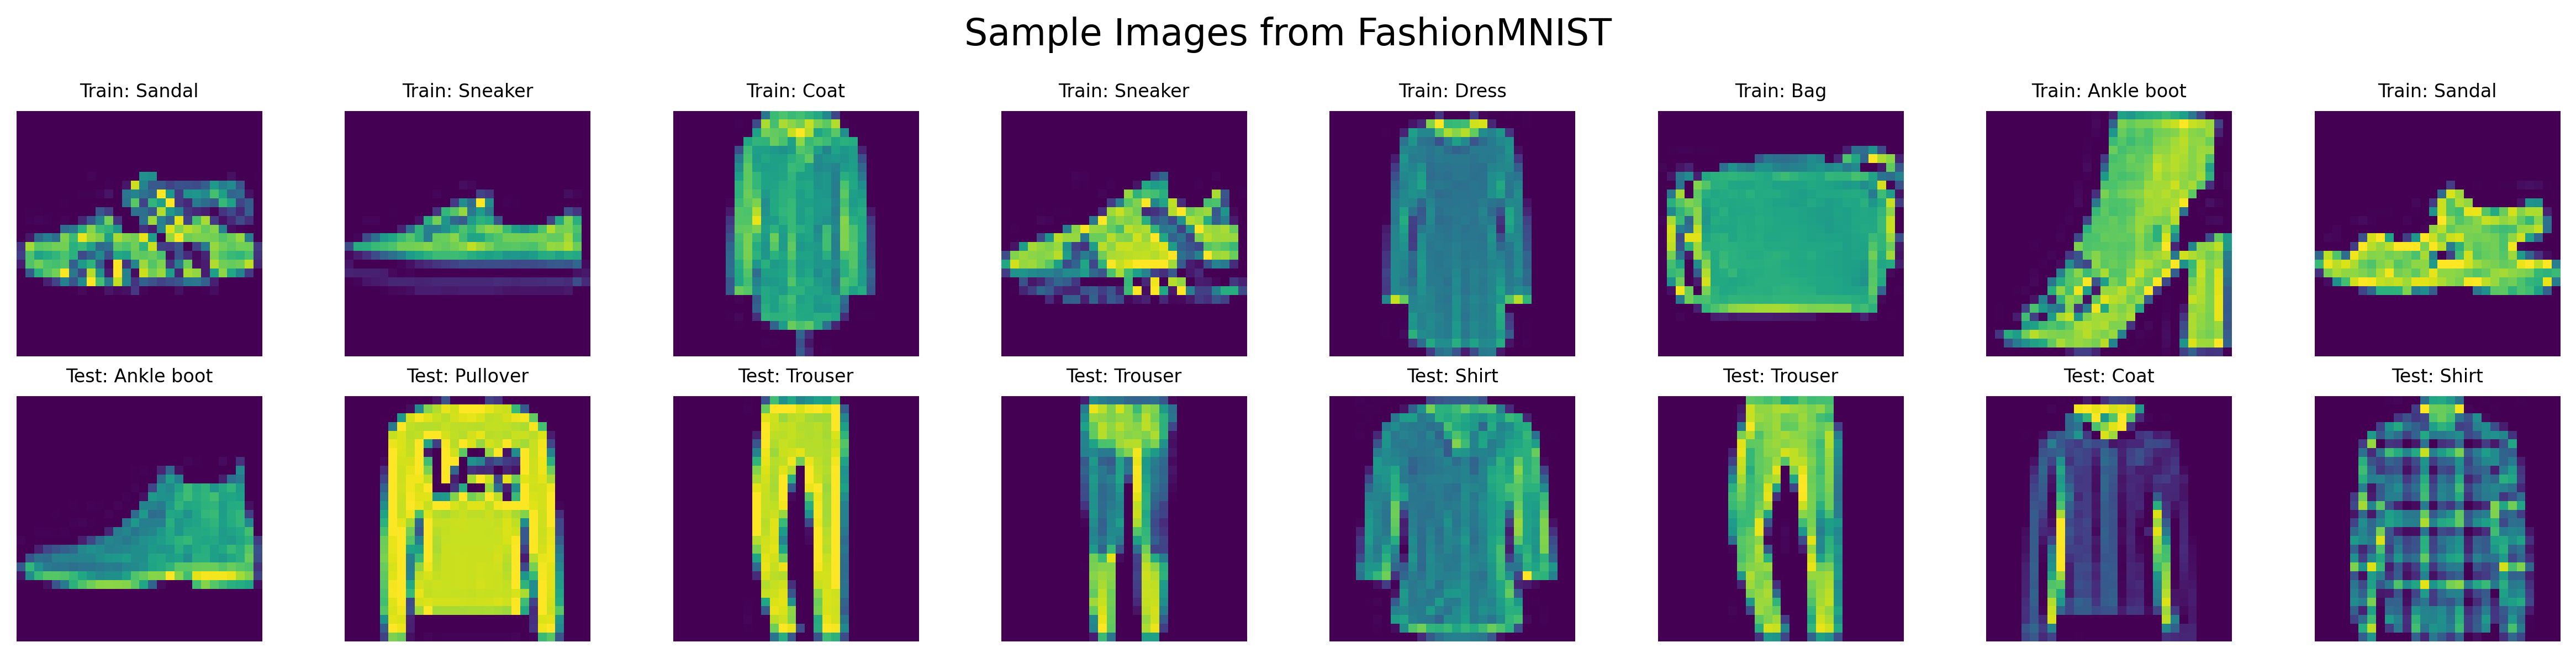


📊 Dataset Summary:
  Input shape: torch.Size([1, 28, 28])
  Number of classes: 10
  Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  Sample batch sizes: train=128, test=128
  Value range: [-1.00, 1.00] (normalized to [-1,1])


In [19]:
# Create data directories
data_dir = project_root / "data"
data_dir.mkdir(exist_ok=True)

print(f"Data directory: {data_dir}")

# OmegaConf is in struct mode, so we need to disable it to add new fields
OmegaConf.set_struct(config, False)  # Disable struct mode temporarily

# Update the config to work with the dataloader function - add missing fields
config.data.dataset_name = config.data.dataset  # dataloader expects 'dataset_name'
config.data.root_dir = str(data_dir)  # dataloader expects 'root_dir'
config.data.download = True
config.data.shuffle_train = True  # Add shuffle settings
config.data.shuffle_test = False

# Add transforms configuration if not present
if 'transforms' not in config.data:
    config.data.transforms = {
        'train': ['ToTensor', 'Normalize'],
        'test': ['ToTensor', 'Normalize']
    }

# Define class names for FashionMNIST
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Update the class names in config
config.data.class_names = class_names

# Re-enable struct mode if desired
OmegaConf.set_struct(config, True)

print("- Configuration updated for FashionMNIST dataset")
print("- Added missing dataloader fields (dataset_name, root_dir, shuffle settings)")
print("- Added transforms configuration")

# Create data loaders using our custom dataloader function
print("Loading dataset and creating data loaders...")
train_loader, test_loader, loaded_class_names = create_dataloaders(config)

print(f"- Train loader: {len(train_loader)} batches")
print(f"- Test loader: {len(test_loader)} batches")
print(f"- Classes: {loaded_class_names}")

# Prepare sample data for visualization using the new function
sample_data = get_sample_batches(train_loader, test_loader, device=device)
print(f"- Prepared sample data for visualization")

# Note: sample_data contains a full batch, we'll only visualize the first 8 samples
# Unpack the sample data
indices_train, images_train, labels_train, indices_test, images_test, labels_test = sample_data

# Visualize some samples
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('Sample Images from FashionMNIST', fontsize=16)

n_viz = min(8, len(images_train))  # Visualize up to 8 samples
for i in range(n_viz):
    # Train samples
    img = images_train[i].cpu().squeeze()
    label = labels_train[i].cpu().item()
    axes[0, i].imshow(img, cmap='viridis')
    axes[0, i].set_title(f'Train: {class_names[label]}', fontsize=8)
    axes[0, i].axis('off')
    
    # Test samples  
    img = images_test[i].cpu().squeeze()
    label = labels_test[i].cpu().item()
    axes[1, i].imshow(img, cmap='viridis')
    axes[1, i].set_title(f'Test: {class_names[label]}', fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Dataset Summary:")
print(f"  Input shape: {images_train[0].shape}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Classes: {class_names}")
print(f"  Sample batch sizes: train={len(images_train)}, test={len(images_test)}")
print(f"  Value range: [{images_train.min():.2f}, {images_train.max():.2f}] (normalized to [-1,1])")

## 4. Initialize ClearML Task

Set up ClearML for experiment tracking. This will log all training metrics, configurations, and artifacts.

In [ ]:
CLEARML = True

if CLEARML:
    # Create a task for this training session
    task = Task.init(
        project_name="ImageDGD", 
        task_name=f"DGD Training Demo - {config.model.representation.distribution}",
        tags=["demo", "notebook", config.data.dataset, f"{config.training.epochs}epochs"]
    )
    
    # Connect the configuration to ClearML
    task.connect(config)
    
    # Set task description
    task.set_comment("""
    DGD Training Demo using DGDTrainer class.
    
    This experiment demonstrates:
    - Deep Generative Decoder training
    - Representation layer learning
    - GMM fitting in latent space
    - Training visualization and monitoring
    """)
    
    print("- ClearML task initialized successfully!")
    print(f"- Project: ImageDGD")
    print(f"- Task: DGD Training Demo - {config.model.representation.distribution}")
    print(f"- Task ID: {task.id}")
    
    # Get dataset sizes from the data loaders
    train_dataset_size = len(train_loader.dataset)
    test_dataset_size = len(test_loader.dataset)
    
    # Log some initial parameters
    task.set_parameters({
        "dataset_size_train": train_dataset_size,
        "dataset_size_test": test_dataset_size,
        "device": str(device),
        "pytorch_version": torch.__version__,
        "subset_used": config.data.use_subset,
        "subset_fraction": config.data.subset_fraction if config.data.use_subset else None
    })

Initializing ClearML task...
- ClearML task initialized successfully!
- Project: ImageDGD
- Task: DGD Training Demo - uniform_ball
- Task ID: 0e3db656d71d44faaa4ad1a675bc24cb
\n📝 Experiment Configuration:
  Project: ImageDGD
  Task: DGD Training Demo
  Dataset: FashionMNIST
  Model: DGD (Deep Generative Decoder)
  Distribution: uniform_ball
  Device: cuda:0
  Tracking: ClearML


## Run Training Process

The trainer will handle everything including model creation, optimization, GMM fitting, and visualization.

In [21]:
trainer = DGDTrainer(
    config=config,
    device=device,
    verbose=True
)

# Start training!
print("Starting DGD training...")
print("=" * 60)

# Record start time
training_start_time = time.time()

try:
    results = trainer.train(
        train_loader=train_loader,
        test_loader=test_loader,
        sample_data=sample_data,
        class_names=class_names
    )
    
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    
    print("\\n" + "=" * 60)
    print("Training completed successfully!")
    print(f"⏱Total training time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")
    
    # Extract results
    model = results['model']
    rep_layer = results['rep']
    test_rep_layer = results['test_rep']
    gmm = results['gmm']
    train_losses = results['train_losses']
    test_losses = results['test_losses']
    
    print(f"\\nFinal Results:")
    print(f"  Final train loss: {results['final_train_loss']:.6f}")
    print(f"  Final test loss: {results['final_test_loss']:.6f}")
    print(f"  Best train loss: {min(train_losses):.6f} (epoch {train_losses.index(min(train_losses)) + 1})")
    print(f"  Best test loss: {min(test_losses):.6f} (epoch {test_losses.index(min(test_losses)) + 1})")
    
    # Model information
    decoder_params = sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
    rep_params = sum(p.numel() for p in rep_layer.parameters() if p.requires_grad)
    test_rep_params = sum(p.numel() for p in test_rep_layer.parameters() if p.requires_grad)
    total_params = decoder_params + rep_params + test_rep_params
    
    print(f"\\nModel Statistics:")
    print(f"  Decoder parameters: {decoder_params:,} ({decoder_params/1e6:.2f}M)")
    print(f"  Train representation parameters: {rep_params:,} ({rep_params/1e6:.2f}M)")
    print(f"  Test representation parameters: {test_rep_params:,} ({test_rep_params/1e6:.2f}M)")
    print(f"  Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")
    
    print(f"\\nGMM Information:")
    print(f"  Number of components: {gmm.n_components}")
    print(f"  Covariance type: {gmm.covariance_type}")
    print(f"  Converged: {gmm.converged_}")
    print(f"  Number of iterations: {gmm.n_iter_}")
    
except Exception as e:
    print(f"Training failed with error: {e}")
    import traceback
    traceback.print_exc()
    raise e

print("\\nTraining completed!")

Starting DGD training...
Decoder parameters: 242,945 (0.24M)
Train representation parameters: 120,000 (0.12M)
Test representation parameters: 20,000 (0.02M)
Total trainable parameters: 382,945 (0.38M)
Training for 200 epochs
Using device: cuda:0
Batch size: 128


KeyboardInterrupt: 

## 7. Analyze Training Results

Let's analyze the training results by examining loss curves, reconstruction quality, and model performance.

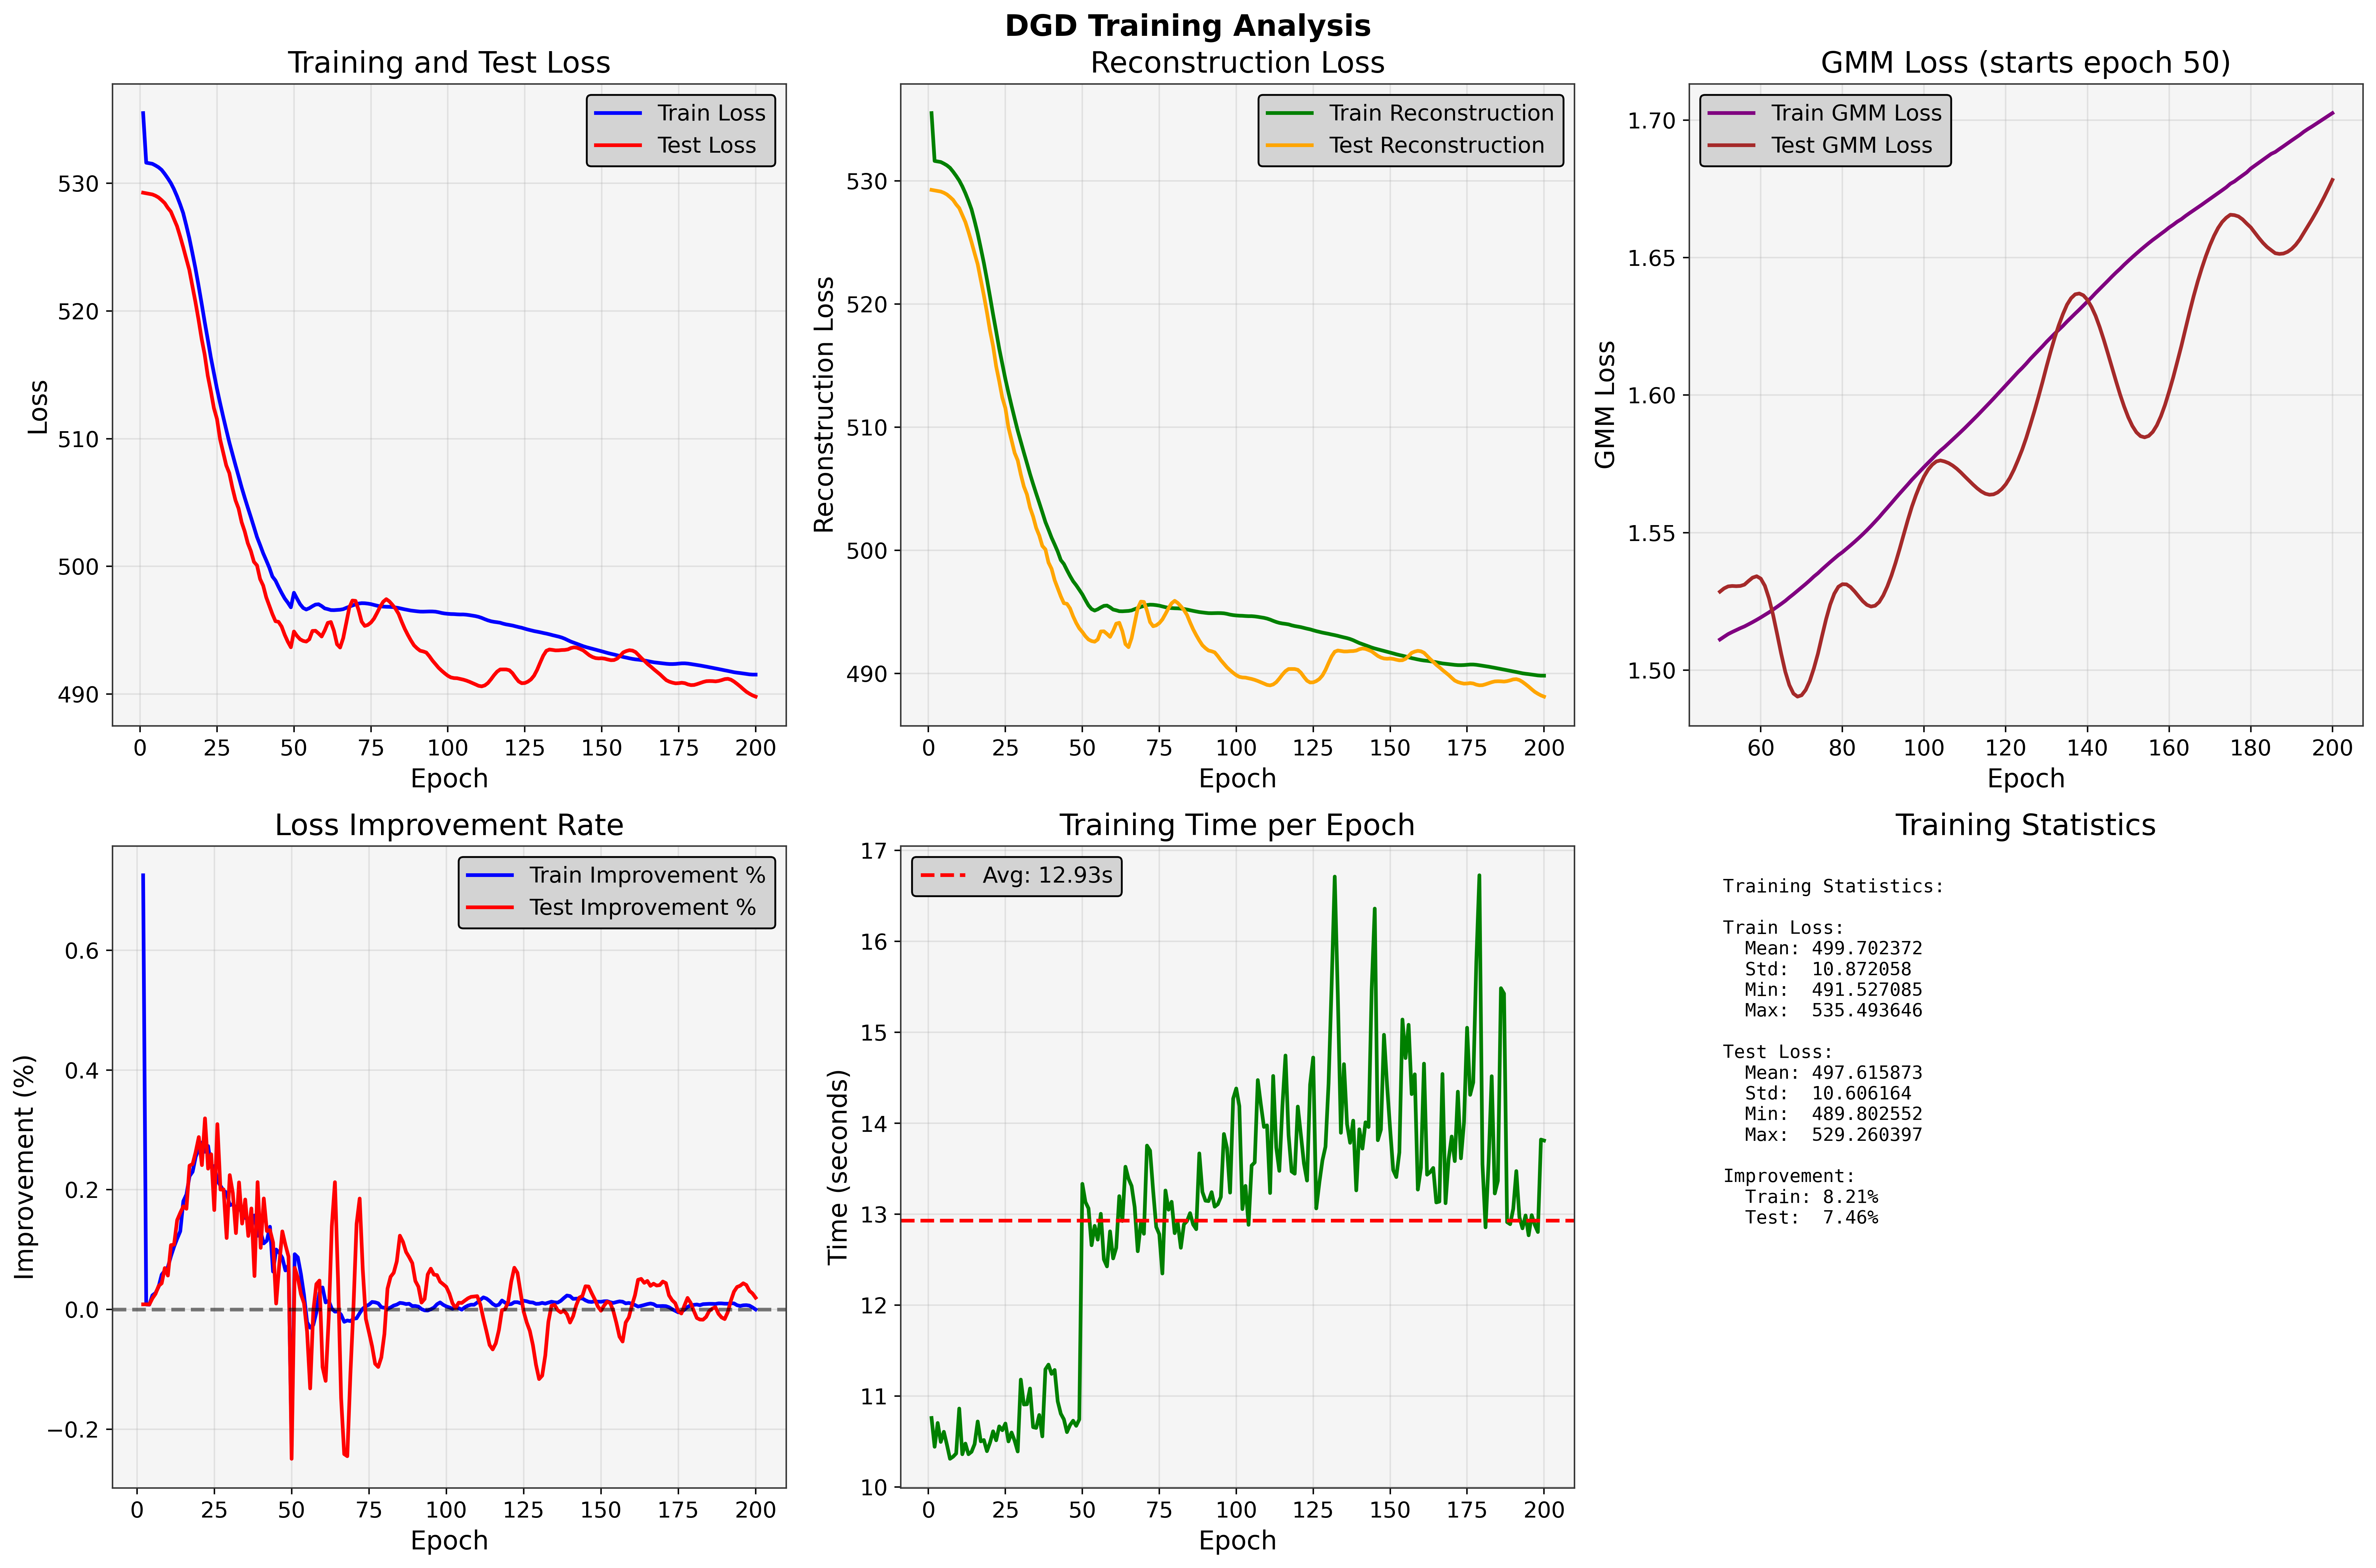

📊 Training Analysis Complete!
- Total epochs: 200
- Training improvement: 8.21%
- Test improvement: 7.46%
- Average epoch time: 12.93 seconds
- GMM fitted: Yes


In [ ]:
# Plot comprehensive training analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('DGD Training Analysis', fontsize=16, fontweight='bold')

# 1. Training and Test Loss
axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(range(1, len(test_losses) + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Reconstruction Losses
recon_train_losses = trainer.recon_train_losses
recon_test_losses = trainer.recon_test_losses
axes[0, 1].plot(range(1, len(recon_train_losses) + 1), recon_train_losses, 'g-', label='Train Reconstruction', linewidth=2)
axes[0, 1].plot(range(1, len(recon_test_losses) + 1), recon_test_losses, 'orange', label='Test Reconstruction', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Reconstruction Loss')
axes[0, 1].set_title('Reconstruction Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. GMM Losses (after GMM starts)
gmm_train_losses = trainer.gmm_train_losses
gmm_test_losses = trainer.gmm_test_losses
gmm_start_epoch = config.training.first_epoch_gmm

if len(gmm_train_losses) > 0 and any(x != 0 for x in gmm_train_losses):
    non_zero_epochs = [i+1 for i, x in enumerate(gmm_train_losses) if x != 0]
    non_zero_train = [x for x in gmm_train_losses if x != 0]
    non_zero_test = [gmm_test_losses[i] for i, x in enumerate(gmm_train_losses) if x != 0]
    
    axes[0, 2].plot(non_zero_epochs, non_zero_train, 'purple', label='Train GMM Loss', linewidth=2)
    axes[0, 2].plot(non_zero_epochs, non_zero_test, 'brown', label='Test GMM Loss', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('GMM Loss')
    axes[0, 2].set_title(f'GMM Loss (starts epoch {gmm_start_epoch})')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'GMM not fitted yet\\nor no GMM loss', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('GMM Loss')

# 4. Loss Improvement Rate
if len(train_losses) > 1:
    train_improvements = [((train_losses[i-1] - train_losses[i]) / train_losses[i-1] * 100) if train_losses[i-1] != 0 else 0 
                         for i in range(1, len(train_losses))]
    test_improvements = [((test_losses[i-1] - test_losses[i]) / test_losses[i-1] * 100) if test_losses[i-1] != 0 else 0 
                        for i in range(1, len(test_losses))]
    
    axes[1, 0].plot(range(2, len(train_losses) + 1), train_improvements, 'b-', label='Train Improvement %', linewidth=2)
    axes[1, 0].plot(range(2, len(test_losses) + 1), test_improvements, 'r-', label='Test Improvement %', linewidth=2)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Improvement (%)')
    axes[1, 0].set_title('Loss Improvement Rate')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# 5. Epoch Times
epoch_times = trainer.epoch_times
if len(epoch_times) > 0:
    axes[1, 1].plot(range(1, len(epoch_times) + 1), epoch_times, 'green', linewidth=2)
    axes[1, 1].axhline(y=np.mean(epoch_times), color='red', linestyle='--', label=f'Avg: {np.mean(epoch_times):.2f}s')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].set_title('Training Time per Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Summary Statistics
train_mean = np.mean(train_losses)
train_std = np.std(train_losses)
test_mean = np.mean(test_losses)
test_std = np.std(test_losses)

stats_text = f"""Training Statistics:

Train Loss:
  Mean: {train_mean:.6f}
  Std:  {train_std:.6f}
  Min:  {min(train_losses):.6f}
  Max:  {max(train_losses):.6f}

Test Loss:
  Mean: {test_mean:.6f}
  Std:  {test_std:.6f}
  Min:  {min(test_losses):.6f}
  Max:  {max(test_losses):.6f}

Improvement:
  Train: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%
  Test:  {((test_losses[0] - test_losses[-1]) / test_losses[0] * 100):.2f}%
"""

axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes, fontsize=10, 
                verticalalignment='top', fontfamily='monospace')
axes[1, 2].set_title('Training Statistics')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("📊 Training Analysis Complete!")
print(f"- Total epochs: {len(train_losses)}")
print(f"- Training improvement: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")
print(f"- Test improvement: {((test_losses[0] - test_losses[-1]) / test_losses[0] * 100):.2f}%")
print(f"- Average epoch time: {np.mean(epoch_times):.2f} seconds")
print(f"- GMM fitted: {'Yes' if gmm.converged_ else 'No'}")

## 8. Model Evaluation and Testing

Let's evaluate the trained model by examining reconstruction quality and computing various metrics.

🔍 Evaluating trained DGD model...
- Reconstruction MSE - Train: 0.645015 ± 0.131636
- Reconstruction MSE - Test: 0.618011 ± 0.150234


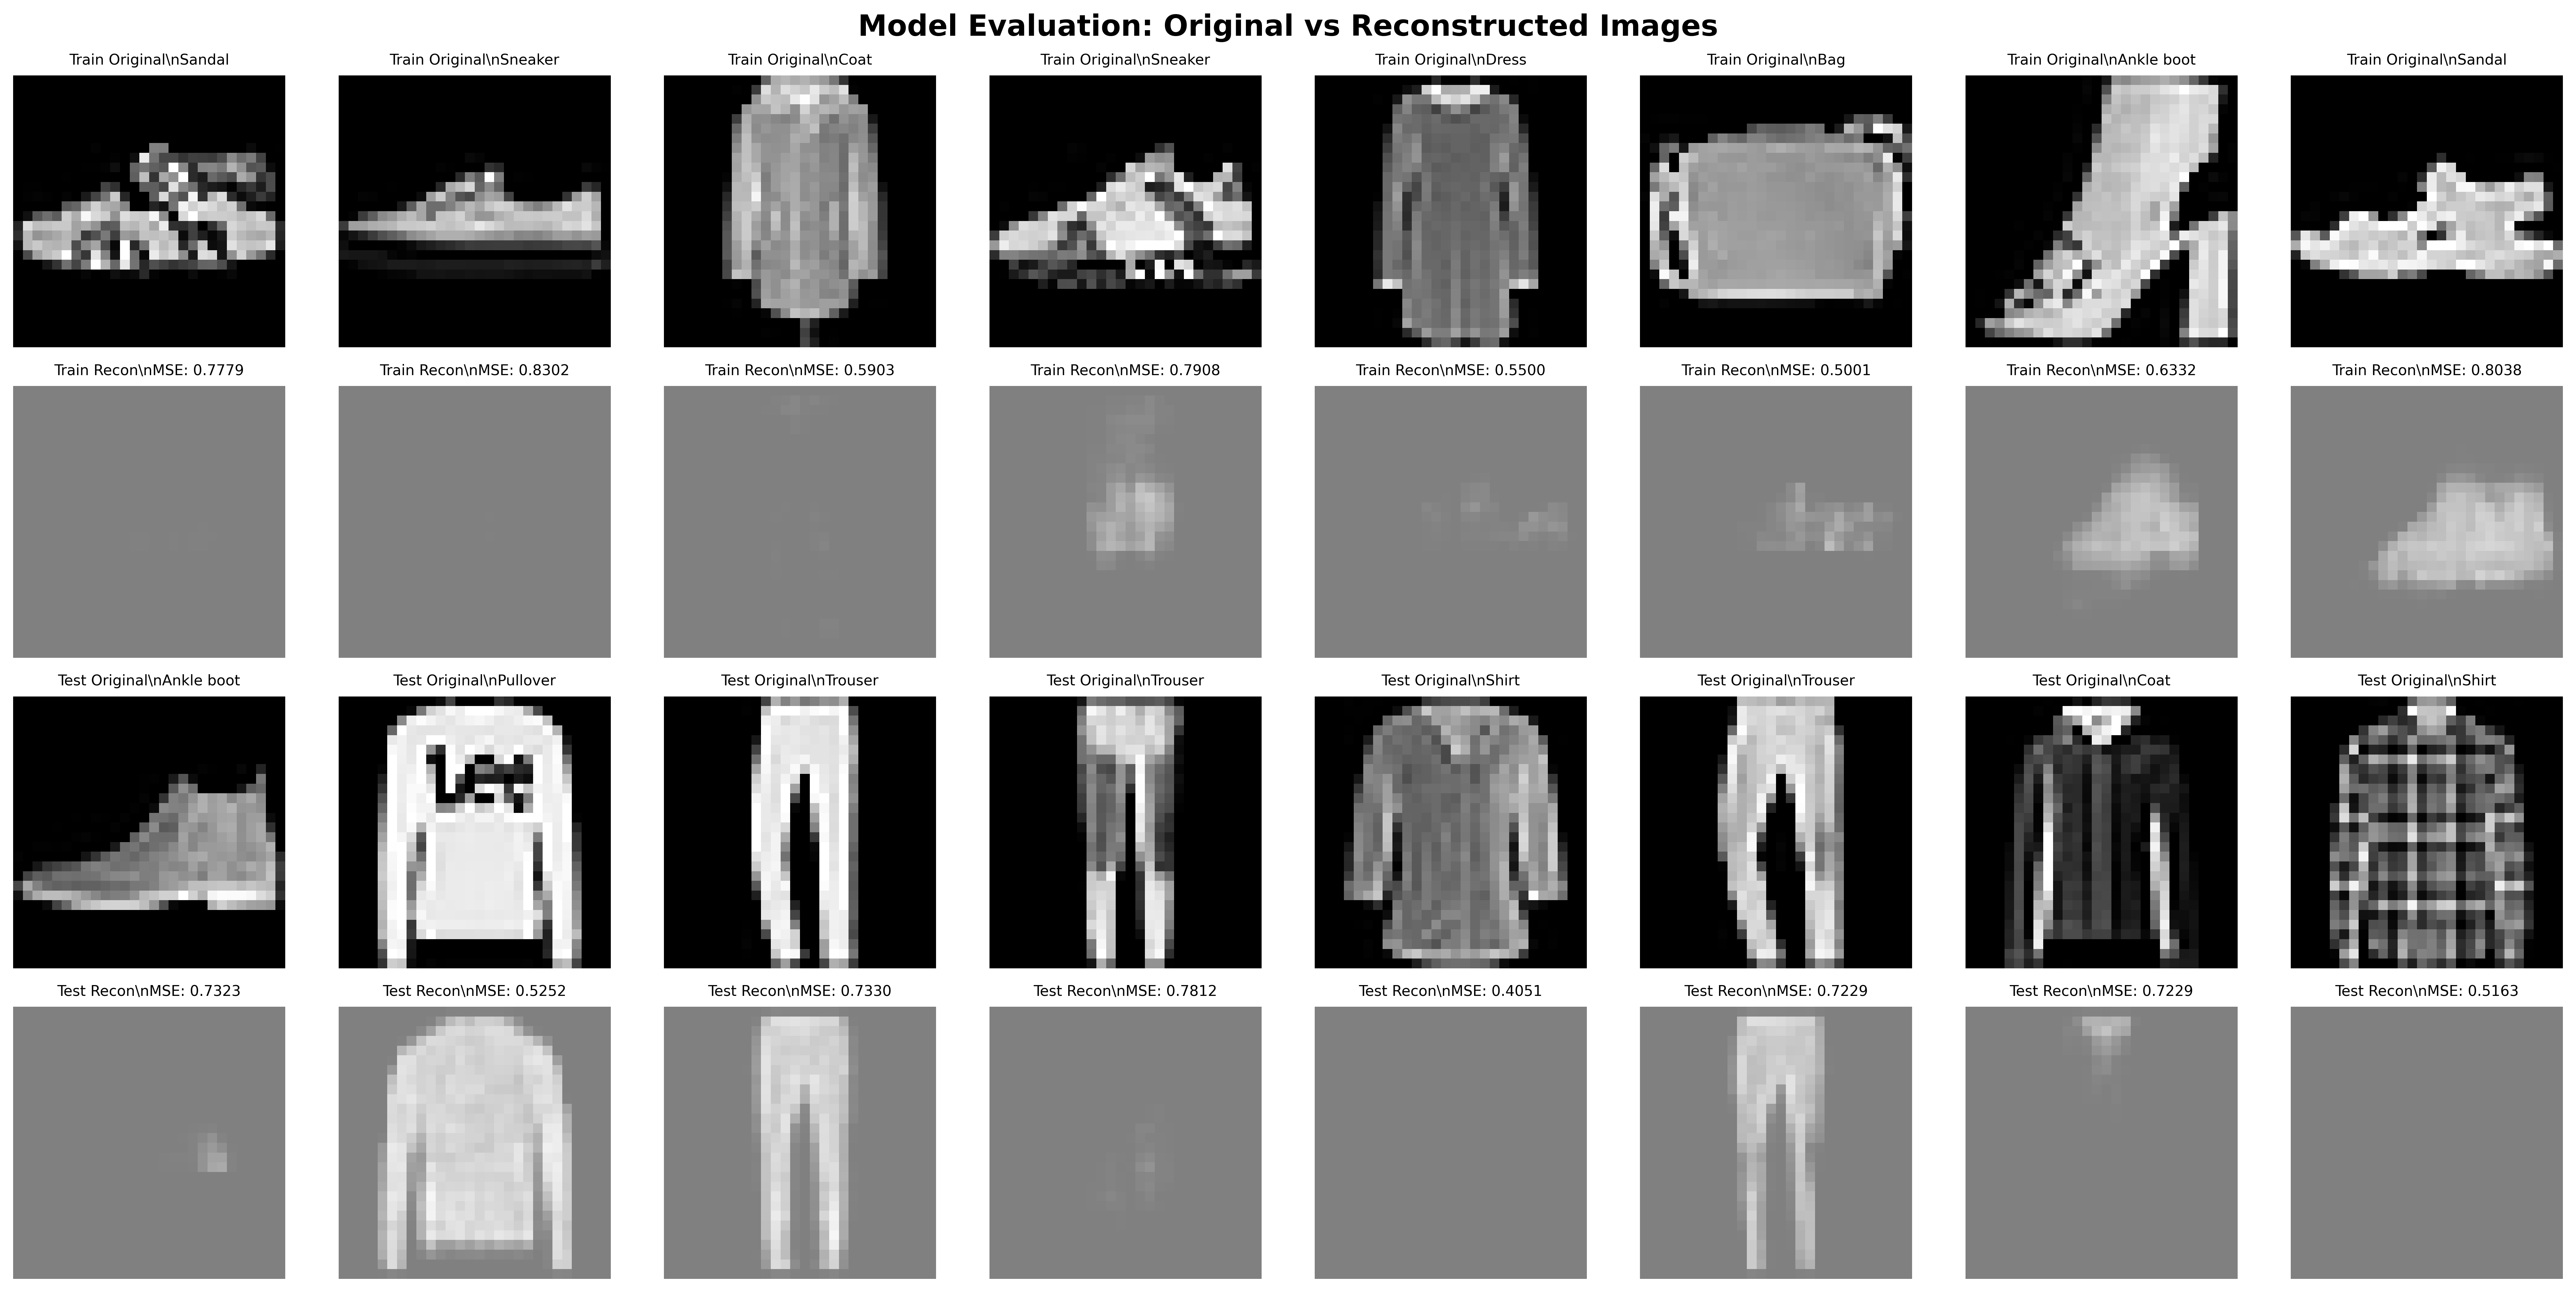

\n📊 Comprehensive Model Evaluation:
\n🎯 Reconstruction Quality:
  Train samples: 60000
  Test samples: 10000
  Sample train MSE: 0.645015 ± 0.131636
  Sample test MSE: 0.618011 ± 0.150234
\n🌌 Latent Space Analysis:
  Latent dimension: 2
  Train latent norm: 0.6868 ± 0.3652
  Test latent norm: 0.6811 ± 0.3661
  Latent range: [-1.128, 1.254]
\n🎲 GMM Evaluation:
  Number of components: 20
  Covariance type: full
  Converged: True
  Iterations: 2
  Train log-likelihood: -1.6353 ± 0.7778
  Test log-likelihood: -1.6231 ± 0.8168
  Component weights: tensor([0.0613, 0.0428, 0.0535, 0.0563, 0.0627, 0.0417, 0.0390, 0.0598, 0.0506,
        0.0538, 0.0418, 0.0546, 0.0413, 0.0381, 0.0406, 0.0455, 0.0529, 0.0622,
        0.0431, 0.0585], device='cuda:0')
  Effective components: 20 / 20
\n✅ Model evaluation completed!


In [ ]:
# Evaluate the trained model
print("🔍 Evaluating trained DGD model...")

# Set model to evaluation mode
model.eval()

# Test reconstruction quality on sample data
with torch.no_grad():
    # Get sample data
    indices_train, images_train, labels_train, indices_test, images_test, labels_test = sample_data
    
    # Move to device
    indices_train = indices_train.to(device)
    images_train = images_train.to(device)
    indices_test = indices_test.to(device)
    images_test = images_test.to(device)
    
    # Generate reconstructions
    z_train = rep_layer(indices_train)
    recon_train = model.decoder(z_train)
    
    z_test = test_rep_layer(indices_test)
    recon_test = model.decoder(z_test)
    
    # Compute reconstruction errors
    train_mse = F.mse_loss(recon_train, images_train, reduction='none').mean(dim=[1,2,3])
    test_mse = F.mse_loss(recon_test, images_test, reduction='none').mean(dim=[1,2,3])
    
    print(f"- Reconstruction MSE - Train: {train_mse.mean():.6f} ± {train_mse.std():.6f}")
    print(f"- Reconstruction MSE - Test: {test_mse.mean():.6f} ± {test_mse.std():.6f}")

# Visualize reconstructions
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
fig.suptitle('Model Evaluation: Original vs Reconstructed Images', fontsize=16, fontweight='bold')

# Convert tensors to CPU and numpy for plotting
images_train_cpu = images_train.cpu()
recon_train_cpu = recon_train.cpu()
images_test_cpu = images_test.cpu()
recon_test_cpu = recon_test.cpu()
labels_train_cpu = labels_train.cpu()
labels_test_cpu = labels_test.cpu()

for i in range(8):
    # Original train images
    img = images_train_cpu[i].squeeze()
    img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
    label = labels_train_cpu[i].item()
    axes[0, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'Train Original\\n{class_names[label]}', fontsize=8)
    axes[0, i].axis('off')
    
    # Reconstructed train images
    img = recon_train_cpu[i].squeeze()
    img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
    mse = train_mse[i].item()
    axes[1, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Train Recon\\nMSE: {mse:.4f}', fontsize=8)
    axes[1, i].axis('off')
    
    # Original test images
    img = images_test_cpu[i].squeeze()
    img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
    label = labels_test_cpu[i].item()
    axes[2, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[2, i].set_title(f'Test Original\\n{class_names[label]}', fontsize=8)
    axes[2, i].axis('off')
    
    # Reconstructed test images
    img = recon_test_cpu[i].squeeze()
    img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
    mse = test_mse[i].item()
    axes[3, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[3, i].set_title(f'Test Recon\\nMSE: {mse:.4f}', fontsize=8)
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()

# Compute comprehensive evaluation metrics
print("\\n📊 Comprehensive Model Evaluation:")

# 1. Overall reconstruction quality
total_train_samples = len(train_loader.dataset)
total_test_samples = len(test_loader.dataset)

print(f"\\n🎯 Reconstruction Quality:")
print(f"  Train samples: {total_train_samples}")
print(f"  Test samples: {total_test_samples}")
print(f"  Sample train MSE: {train_mse.mean():.6f} ± {train_mse.std():.6f}")
print(f"  Sample test MSE: {test_mse.mean():.6f} ± {test_mse.std():.6f}")

# 2. Latent space analysis
z_train_norm = torch.norm(z_train, dim=1)
z_test_norm = torch.norm(z_test, dim=1)

print(f"\\n🌌 Latent Space Analysis:")
print(f"  Latent dimension: {z_train.shape[1]}")
print(f"  Train latent norm: {z_train_norm.mean():.4f} ± {z_train_norm.std():.4f}")
print(f"  Test latent norm: {z_test_norm.mean():.4f} ± {z_test_norm.std():.4f}")
print(f"  Latent range: [{z_train.min():.3f}, {z_train.max():.3f}]")

# 3. GMM evaluation
if gmm.converged_:
    # Compute log-likelihood of representations
    train_log_likelihood = gmm.score_samples(z_train)
    test_log_likelihood = gmm.score_samples(z_test)
    
    print(f"\\n🎲 GMM Evaluation:")
    print(f"  Number of components: {gmm.n_components}")
    print(f"  Covariance type: {gmm.covariance_type}")
    print(f"  Converged: {gmm.converged_}")
    print(f"  Iterations: {gmm.n_iter_}")
    print(f"  Train log-likelihood: {train_log_likelihood.mean():.4f} ± {train_log_likelihood.std():.4f}")
    print(f"  Test log-likelihood: {test_log_likelihood.mean():.4f} ± {test_log_likelihood.std():.4f}")
    
    # Component weights
    weights = gmm.weights_
    print(f"  Component weights: {weights}")
    print(f"  Effective components: {(weights > 0.01).sum()} / {len(weights)}")
else:
    print(f"\\n⚠️ GMM did not converge (iterations: {gmm.n_iter_})")

print("\\n✅ Model evaluation completed!")

## 9. Generate Samples from Trained Model

Now let's generate new samples using the trained GMM and explore the latent space capabilities.

🎨 Generating samples from trained DGD model...
- Generated 32 samples from GMM
- Sample shape: torch.Size([32, 1, 28, 28])
- Component distribution: [2 2 3 1 3 2 3 2 2 0 1 2 0 1 2 0 2 1 2 1]


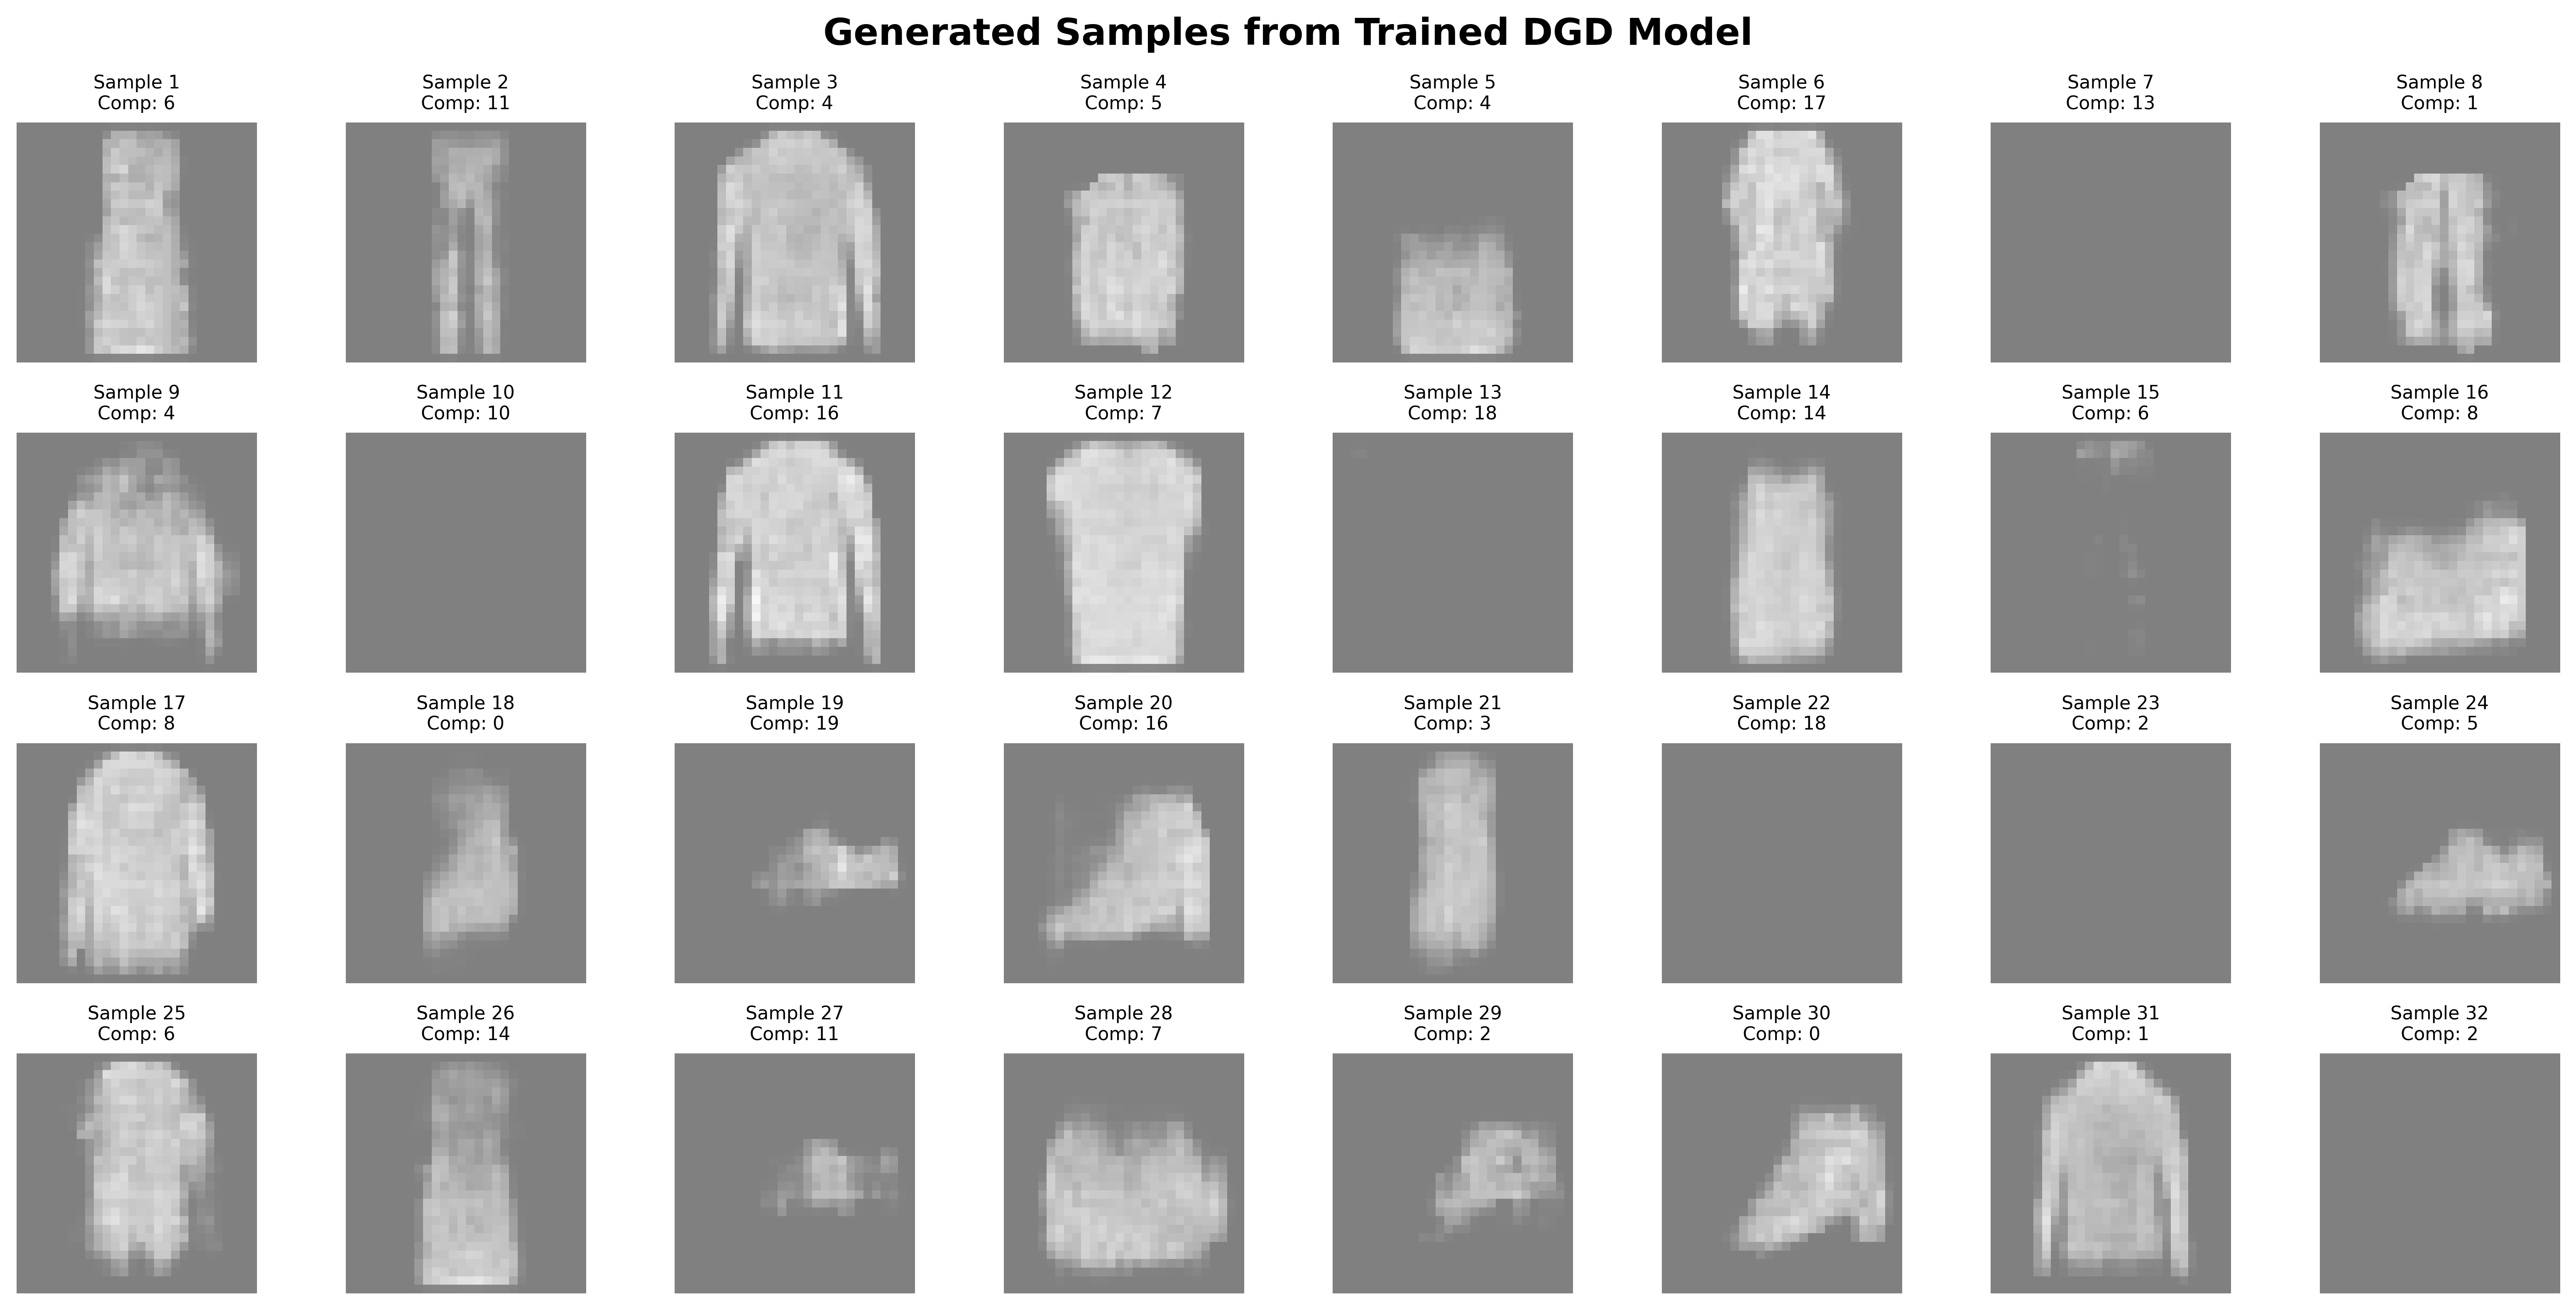


🎯 Generating samples from individual GMM components...


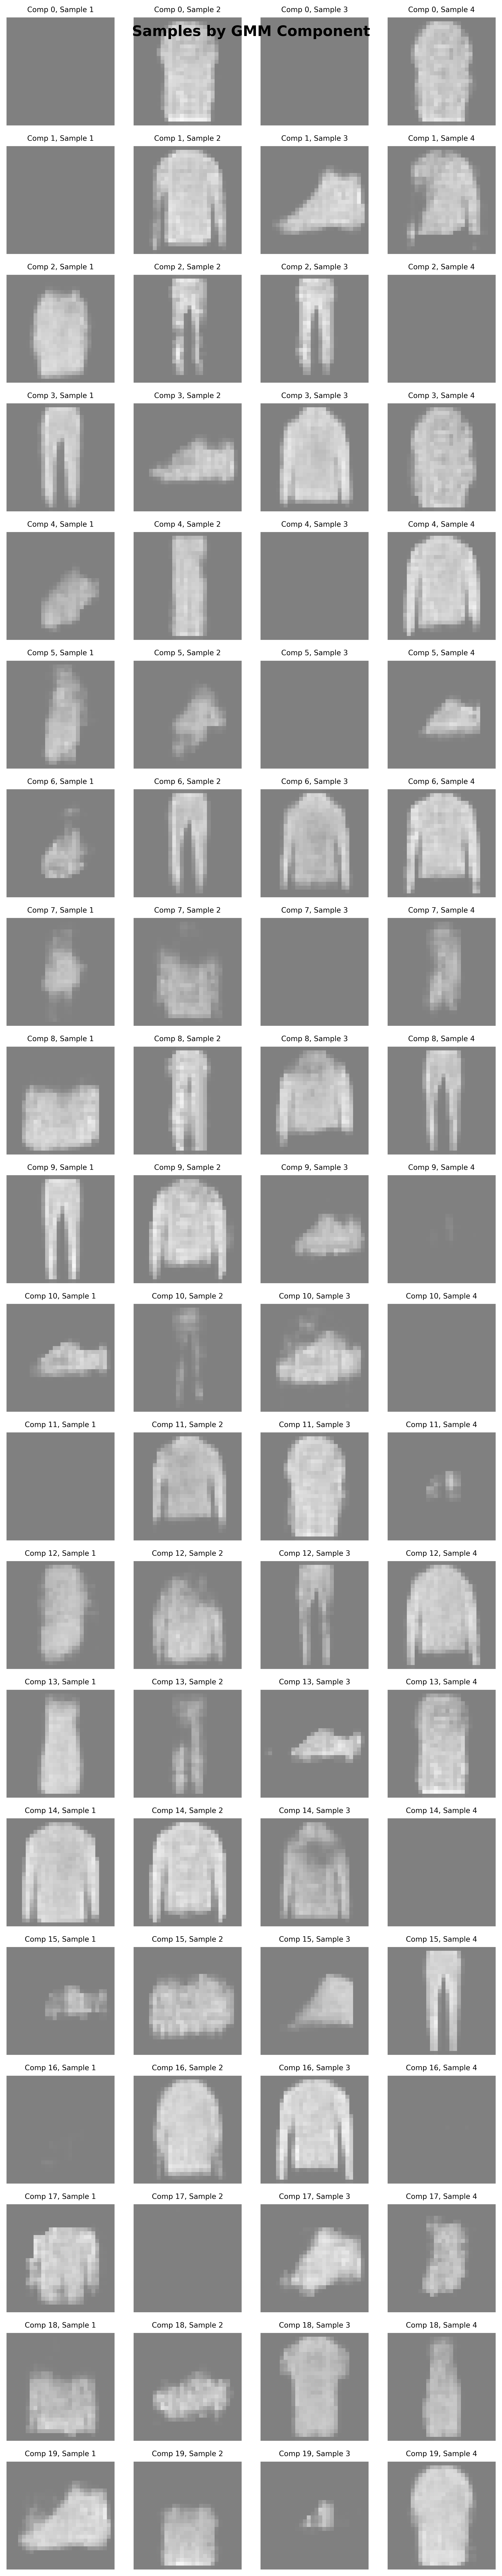

In [ ]:
# Generate samples from the trained model
print("🎨 Generating samples from trained DGD model...")

if gmm.converged_:
    with torch.no_grad():
        # 1. Sample from GMM
        n_samples = 32
        z_samples, component_labels = gmm.sample(n_samples)
        
        # Generate images from samples
        generated_images = model.decoder(z_samples)
        
        print(f"- Generated {n_samples} samples from GMM")
        print(f"- Sample shape: {generated_images.shape}")
        print(f"- Component distribution: {np.bincount(component_labels.cpu().numpy())}")
        
        # Visualize generated samples
        fig, axes = plt.subplots(4, 8, figsize=(16, 8))
        fig.suptitle('Generated Samples from Trained DGD Model', fontsize=16, fontweight='bold')
        
        generated_images_cpu = generated_images.cpu()
        component_labels_cpu = component_labels.cpu()
        
        for i in range(min(32, n_samples)):
            row = i // 8
            col = i % 8
            
            img = generated_images_cpu[i].squeeze()
            img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
            component = component_labels_cpu[i].item()
            
            axes[row, col].imshow(img, cmap='gray', vmin=0, vmax=1)
            axes[row, col].set_title(f'Sample {i+1}\nComp: {component}', fontsize=8)
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 2. Sample from each GMM component separately
        print("\n🎯 Generating samples from individual GMM components...")
        
        def sample_from_component(gmm, n_samples, component_idx):
            """Sample n_samples from a specific GMM component."""
            # Get the mean and covariance for the specific component
            mean = gmm.means_[component_idx]
            
            # Handle different covariance types
            if gmm.covariance_type == 'full':
                cov = gmm.covariances_[component_idx]
            elif gmm.covariance_type == 'diag':
                cov = torch.diag_embed(gmm.covariances_[component_idx])
            elif gmm.covariance_type == 'spherical':
                cov = torch.eye(gmm.n_features, device=gmm.device) * gmm.covariances_[component_idx]
            elif gmm.covariance_type == 'tied_full':
                cov = gmm.covariances_
            elif gmm.covariance_type == 'tied_diag':
                cov = torch.diag_embed(gmm.covariances_)
            elif gmm.covariance_type == 'tied_spherical':
                cov = torch.eye(gmm.n_features, device=gmm.device) * gmm.covariances_
            else:
                raise ValueError(f"Unsupported covariance type: {gmm.covariance_type}")
            
            # Sample from the multivariate normal distribution
            dist = torch.distributions.MultivariateNormal(mean, cov)
            samples = dist.sample((n_samples,))
            return samples
        
        # Generate samples from each component
        n_per_component = 4
        fig, axes = plt.subplots(gmm.n_components, n_per_component, figsize=(n_per_component*2, gmm.n_components*2))
        fig.suptitle('Samples by GMM Component', fontsize=16, fontweight='bold')
        
        for comp in range(gmm.n_components):
            # Sample from specific component
            z_comp = sample_from_component(gmm, n_per_component, comp)
            imgs_comp = model.decoder(z_comp)
            
            for j in range(n_per_component):
                img = imgs_comp[j].cpu().squeeze()
                img = torch.clamp((img + 1) / 2, 0, 1)
                
                if gmm.n_components == 1:
                    axes[j].imshow(img, cmap='gray', vmin=0, vmax=1)
                    axes[j].set_title(f'Comp {comp}, Sample {j+1}', fontsize=8)
                    axes[j].axis('off')
                else:
                    axes[comp, j].imshow(img, cmap='gray', vmin=0, vmax=1)
                    axes[comp, j].set_title(f'Comp {comp}, Sample {j+1}', fontsize=8)
                    axes[comp, j].axis('off')
        
        plt.tight_layout()
        plt.show()
        
else:
    print("⚠️ GMM did not converge - cannot generate meaningful samples")
    print("💡 Try training for more epochs or adjusting GMM parameters")

## 10. Save and Export Model

Finally, let's save the trained model components and demonstrate how to load them for future use.

In [ ]:
# Save the trained model components
print("💾 Saving trained DGD model components...")

# Create model save directory
model_dir = project_root / "models" / "dgd_demo"
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Model save directory: {model_dir}")

# 1. Save model state dictionaries
torch.save(model.decoder.state_dict(), model_dir / "decoder.pth")
torch.save(rep_layer.state_dict(), model_dir / "train_representation.pth")
torch.save(test_rep_layer.state_dict(), model_dir / "test_representation.pth")

print("- Saved PyTorch model state dictionaries")

# 2. Save GMM model
import pickle
with open(model_dir / "gmm.pkl", "wb") as f:
    pickle.dump(gmm, f)

print("- Saved GMM model")

# 3. Save configuration
OmegaConf.save(config, model_dir / "config.yaml")

print("- Saved configuration")

# 4. Save training results
training_results = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'recon_train_losses': trainer.recon_train_losses,
    'recon_test_losses': trainer.recon_test_losses,
    'gmm_train_losses': trainer.gmm_train_losses,
    'gmm_test_losses': trainer.gmm_test_losses,
    'epoch_times': trainer.epoch_times,
    'final_train_loss': results['final_train_loss'],
    'final_test_loss': results['final_test_loss'],
    'total_time': results['total_time']
}

torch.save(training_results, model_dir / "training_results.pth")

print("- Saved training results")

# 5. Save model metadata
metadata = {
    'model_type': 'DGD',
    'dataset': config.data.dataset,
    'epochs_trained': len(train_losses),
    'latent_dim': config.model.representation.n_features,
    'decoder_params': sum(p.numel() for p in model.decoder.parameters()),
    'rep_params': sum(p.numel() for p in rep_layer.parameters()),
    'gmm_components': gmm.n_components,
    'gmm_converged': gmm.converged_,
    'training_date': time.strftime('%Y-%m-%d %H:%M:%S'),
    'device_used': str(device),
    'pytorch_version': torch.__version__
}

torch.save(metadata, model_dir / "metadata.pth")

print("- Saved model metadata")

# List all saved files
saved_files = list(model_dir.glob("*"))
print(f"\\n📁 Saved files ({len(saved_files)} total):")
for file in saved_files:
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  {file.name}: {size_mb:.2f} MB")

print("\\n" + "="*60)
print("🔄 Demonstrating Model Loading...")

# Demonstrate loading the saved model
def load_dgd_model(model_dir, device):
    """Load a saved DGD model from directory."""
    print(f"Loading DGD model from {model_dir}...")
    
    # Load configuration
    config_loaded = OmegaConf.load(model_dir / "config.yaml")
    
    # Load metadata
    metadata = torch.load(model_dir / "metadata.pth", map_location=device)
    
    # Recreate decoder
    decoder_loaded = ConvDecoder(
        latent_dim=config_loaded.model.representation.n_features,
        hidden_dims=config_loaded.model.decoder.hidden_dims,
        output_channels=config_loaded.model.decoder.output_channels,
        output_size=config_loaded.model.decoder.output_size,
        use_batch_norm=config_loaded.model.decoder.use_batch_norm,
        activation=config_loaded.model.decoder.activation,
        final_activation=config_loaded.model.decoder.final_activation,
        dropout_rate=config_loaded.model.decoder.dropout_rate,
        init_size=config_loaded.model.decoder.init_size
    ).to(device)
    
    # Load decoder weights
    decoder_loaded.load_state_dict(torch.load(model_dir / "decoder.pth", map_location=device))
    
    # Load GMM
    with open(model_dir / "gmm.pkl", "rb") as f:
        gmm_loaded = pickle.load(f)
    
    # Recreate representation layers (for new data)
    rep_loaded = RepresentationLayer(
        dim=config_loaded.model.representation.n_features,
        n_samples=1000,  # Can be changed for new datasets
        dist=config_loaded.model.representation.distribution,
        dist_params={'radius': config_loaded.model.representation.radius} if hasattr(config_loaded.model.representation, 'radius') else {},
        device=device
    )
    
    # Create DGD model
    model_loaded = DGD(decoder_loaded, rep_loaded, gmm_loaded)
    
    print("- Model loaded successfully!")
    return model_loaded, config_loaded, metadata

# Load the model
loaded_model, loaded_config, loaded_metadata = load_dgd_model(model_dir, device)

print("✅ Model loading demonstration completed!")
print(f"- Loaded model trained for {loaded_metadata['epochs_trained']} epochs")
print(f"- Model parameters: {loaded_metadata['decoder_params']:,}")
print(f"- GMM converged: {loaded_metadata['gmm_converged']}")
print(f"- Training date: {loaded_metadata['training_date']}")

# Test the loaded model with a sample
print("\\n🧪 Testing loaded model...")
with torch.no_grad():
    # Sample from loaded GMM
    z_test_load, _ = loaded_model.gmm.sample(4)
    img_test_load = loaded_model.decoder(z_test_load)
    
    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    fig.suptitle('Samples from Loaded Model', fontsize=12, fontweight='bold')
    
    for i in range(4):
        img = img_test_load[i].cpu().squeeze()
        img = torch.clamp((img + 1) / 2, 0, 1)
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f'Sample {i+1}', fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("- Loaded model generates samples correctly!")

# Final summary
print("\\n" + "="*60)
print("🎉 DGD Training Demo Complete!")
print("="*60)
print("\\n📋 Summary:")
print(f"✅ Trained DGD model for {len(train_losses)} epochs")
print(f"✅ Final train loss: {results['final_train_loss']:.6f}")
print(f"✅ Final test loss: {results['final_test_loss']:.6f}")
print(f"✅ GMM fitted with {gmm.n_components} components")
print(f"✅ Model saved to: {model_dir}")
print(f"✅ Model loading verified")
print(f"✅ Sample generation working")

print("\\n🚀 Next Steps:")
print("• Try different configurations (latent dimensions, architectures)")
print("• Experiment with different datasets")
print("• Adjust GMM parameters for better clustering")
print("• Use longer training for better convergence")
print("• Explore different representation distributions")
print("• Use ClearML for experiment tracking and comparison")

if task:
    print(f"\\n📊 View results in ClearML: Task ID {task.id}")
    # Mark task as completed
    task.mark_completed()

print("\\n🎯 DGDTrainer Usage Demonstrated Successfully!")

💾 Saving trained DGD model components...
Model save directory: /home/asp/Downloads/HeaDS/ImageDGD/models/dgd_demo
- Saved PyTorch model state dictionaries
- Saved GMM model
- Saved configuration
- Saved PyTorch model state dictionaries
- Saved GMM model
- Saved configuration
- Saved training results
- Saved training results
- Saved model metadata
\n📁 Saved files (7 total):
  config.yaml: 0.00 MB
  decoder.pth: 0.94 MB
  gmm.pkl: 0.00 MB
  metadata.pth: 0.00 MB
  test_representation.pth: 0.08 MB
  train_representation.pth: 0.46 MB
  training_results.pth: 0.01 MB
\n============================================================
🔄 Demonstrating Model Loading...
Loading DGD model from /home/asp/Downloads/HeaDS/ImageDGD/models/dgd_demo...
- Saved model metadata
\n📁 Saved files (7 total):
  config.yaml: 0.00 MB
  decoder.pth: 0.94 MB
  gmm.pkl: 0.00 MB
  metadata.pth: 0.00 MB
  test_representation.pth: 0.08 MB
  train_representation.pth: 0.46 MB
  training_results.pth: 0.01 MB
\n===============

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.torch_version.TorchVersion was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch.torch_version.TorchVersion])` or the `torch.serialization.safe_globals([torch.torch_version.TorchVersion])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.